In [1]:
import wrangle as w
# import data tools
import numpy as np
import pandas as pd
# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.cluster import KMeans

In [2]:
train, validate, test = w.wrangle()

In [3]:
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type_of_wine_white
3737,5.5,0.24,0.32,8.70,0.060,19.0,102.0,0.99400,3.27,0.31,10.4,5,1
19,7.9,0.32,0.51,1.80,0.341,17.0,56.0,0.99690,3.04,1.08,9.2,6,0
2200,7.2,0.24,0.40,1.40,0.045,31.0,106.0,0.99140,2.88,0.38,10.8,6,1
4139,9.0,0.29,0.34,12.10,0.030,34.0,177.0,0.99706,3.13,0.47,10.6,5,1
501,10.4,0.44,0.73,6.55,0.074,38.0,76.0,0.99900,3.17,0.85,12.0,7,0


In [4]:
test.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type_of_wine_white
1321,5.0,0.74,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,6,0
2767,7.2,0.20,0.38,1.00,0.037,21.0,74.0,0.99180,3.21,0.37,11.0,5,1
5069,6.7,0.24,0.30,3.85,0.042,105.0,179.0,0.99189,3.04,0.59,11.3,8,1
5780,6.6,0.25,0.32,5.60,0.039,15.0,68.0,0.99163,2.96,0.52,11.1,6,1
547,10.6,0.31,0.49,2.50,0.067,6.0,21.0,0.99870,3.26,0.86,10.7,6,0


In [5]:
drops = ['quality', 'type_of_wine_white']

In [6]:
cols = train.drop(columns=drops).columns.to_list()

In [7]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test)

In [8]:
# X_train = train_scaled.drop(columns=drops)
X_train = train.drop(columns=drops)
y_train = train.quality
# X_validate = validate_scaled.drop(columns=drops)
X_validate = validate.drop(columns=drops)
y_validate = validate.quality
# X_test = test_scaled.drop(columns=drops)
X_test = test.drop(columns=drops)
y_test = test.quality

In [9]:
# convert the y-variable lists into dataFrames
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

## Feature selection


In [10]:
# K-Best selector
# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 3 X's correlated with y
f_selector.fit(X_train[cols], y_train.quality)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature_kbest = X_train.iloc[:,feature_mask].columns.tolist()

In [11]:
f_feature_kbest

['volatile_acidity', 'chlorides', 'density', 'alcohol']

In [12]:
# RFE selector

lm = LinearRegression()
# parameters: f_regression stats test, give me 4 features
f_selector = RFE(lm, n_features_to_select=4)

# find the top 3 X's correlated with y
f_selector.fit(X_train[cols], y_train.quality)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature_rfe = X_train.iloc[:,feature_mask].columns.tolist()

In [13]:
f_feature_rfe

['volatile_acidity', 'chlorides', 'density', 'sulphates']

In [70]:
f_features = ['volatile_acidity', 'chlorides', 'density', 'alcohol']

# Modeling

## Establish Baseline

In [14]:
# add mean quality scores to y DataFrames
y_train['quality_pred_mean'] = y_train.quality.mean()
y_validate['quality_pred_mean'] = y_train.quality.mean()
# add median quality scores to y DataFrames
y_train['quality_pred_med'] = y_train.quality.median()
y_validate['quality_pred_med'] = y_train.quality.median()

In [15]:
# get RMSE scores for baseline based on mean
rmse_train_mu = mean_squared_error(y_train.quality,
                                   y_train.quality_pred_mean, squared=False)
rmse_validate_mu = mean_squared_error(y_validate.quality, 
                                      y_validate.quality_pred_mean, squared=False)
# get RMSE scores for baseline based on median
rmse_train_med = mean_squared_error(y_train.quality, 
                                    y_train.quality_pred_med, squared=False)
rmse_validate_med = mean_squared_error(y_validate.quality, 
                                       y_validate.quality_pred_med, squared=False)

In [16]:
metric_df = pd.DataFrame(data=[
    {
        'model' : 'mean_baseline',
        'RMSE_train' : rmse_train_mu,
        'RMSE_validate' : rmse_validate_mu,
        'difference' : rmse_validate_mu - rmse_train_mu,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_mean)
    }
])

In [17]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,0.866273,0.889468,0.023195,0.0


In [18]:
def get_baseline_model(y_train):
    '''
    This function will print the mean baseline RMSE and R^2 scores
    '''
    # get the mean value of quality scores from the training data
    y_train['quality_pred_mean'] = y_train.quality.mean()
    # calculate RMSE for the mean
    rmse_train_mu = mean_squared_error(y_train.quality,
                                   y_train.quality_pred_mean, squared=False)
    # print results
    print('Baseline Model (mean)')
    print(f'RMSE for baseline model: {rmse_train_mu:.08}')
    # r^2 for the baseline will always be 0 by definition
    print('R^2 for baseline model: 0.0')

In [19]:
get_baseline_model(y_train)

Baseline Model (mean)
RMSE for baseline model: 0.86627299
R^2 for baseline model: 0.0


## Oridinary Least Squares - kbest features

In [20]:
# make the model
lm_kbest = LinearRegression()
# fit the model on the training data
lm_kbest.fit(X_train[f_feature_kbest], y_train.quality)
# use the model make predictions on the training data
y_train['quality_pred_lm_kbest'] = lm_kbest.predict(X_train[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lm_kbest, squared=False)

# repeat usage on validate
y_validate['quality_pred_lm_kbest'] = lm_kbest.predict(
    X_validate[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lm_kbest, squared=False)

In [21]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'OLS-KBest features',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lm_kbest)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/4216574684.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## Oridinary Least Squares - rfe features

In [22]:
# make the model
lm_rfe = LinearRegression()
# fit the model on the training data
lm_rfe.fit(X_train[f_feature_rfe], y_train.quality)
# use the model make predictions on the training data
y_train['quality_pred_lm_rfe'] = lm_rfe.predict(X_train[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lm_rfe, squared=False)

# repeat usage on validate
y_validate['quality_pred_lm_rfe'] = lm_rfe.predict(
    X_validate[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lm_rfe, squared=False)

In [23]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'OLS-rfe features',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lm_rfe)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/2271138136.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [24]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,0.866273,0.889468,0.023195,0.000000
1,OLS-KBest features,0.743465,0.755903,0.012438,0.277938
2,OLS-rfe features,0.796045,0.801053,0.005008,0.189190


## LASSO + LARS - 0.1 - kbest features

In [25]:
# make la thing
lars_kbest = LassoLars(alpha=0.1)
# fit za thing
lars_kbest.fit(X_train[f_feature_kbest], y_train.quality)
# usage of a thing
y_train['quality_pred_lars_01_kbest'] = lars_kbest.predict(
    X_train[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lars_01_kbest, squared=False)

# repeat usage on validate
y_validate['quality_pred_lars_01_kbest'] = lars_kbest.predict(
    X_validate[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lars_01_kbest, squared=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [26]:
#Append the lars model to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Lasso + Lars-kbest-0.1',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lars_01_kbest)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/2002484926.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## LASSO + LARS - 0.1 - rfe features

In [27]:
# make la thing
lars_rfe = LassoLars(alpha=0.1)
# fit za thing
lars_rfe.fit(X_train[f_feature_rfe], y_train.quality)
# usage of a thing
y_train['quality_pred_lars_01_rfe'] = lars_rfe.predict(
    X_train[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lars_01_rfe, squared=False)

# repeat usage on validate
y_validate['quality_pred_lars_01_rfe'] = lars_rfe.predict(
    X_validate[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lars_01_rfe, squared=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [28]:
#Append the lars model to the metric_df
metric_df = metric_df.append(
    {
        'model' : 'Lasso + Lars-rfe-0.1',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lars_01_rfe)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/1391429626.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [29]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,0.866273,0.889468,0.023195,0.000000
1,OLS-KBest features,0.743465,0.755903,0.012438,0.277938
2,OLS-rfe features,0.796045,0.801053,0.005008,0.189190
3,Lasso + Lars-kbest-0.1,0.866273,0.889468,0.023195,0.000000
4,Lasso + Lars-rfe-0.1,0.866273,0.889468,0.023195,0.000000


## LASSO + LARS - 0.01 - kbest features

In [30]:
# make la thing
lars_kbest = LassoLars(alpha=0.01)
# fit za thing
lars_kbest.fit(X_train[f_feature_kbest], y_train.quality)
# usage of a thing
y_train['quality_pred_lars_001_kbest'] = lars_kbest.predict(
    X_train[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lars_001_kbest, squared=False)

# repeat usage on validate
y_validate['quality_pred_lars_001_kbest'] = lars_kbest.predict(
    X_validate[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lars_001_kbest, squared=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [31]:
#Append the lars model to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Lasso + Lars-kbest-0.01',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lars_001_kbest)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/4066721071.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## LASSO + LARS - 0.01 - rfe features

In [32]:
# make la thing
lars_rfe = LassoLars(alpha=0.01)
# fit za thing
lars_rfe.fit(X_train[f_feature_rfe], y_train.quality)
# usage of a thing
y_train['quality_pred_lars_001_rfe'] = lars_rfe.predict(
    X_train[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lars_001_rfe, squared=False)

# repeat usage on validate
y_validate['quality_pred_lars_001_rfe'] = lars_rfe.predict(
    X_validate[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lars_001_rfe, squared=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [33]:
#Append the lars model to the metric_df
metric_df = metric_df.append(
    {
        'model' : 'Lasso + Lars-rfe-0.01',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lars_001_rfe)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/2307692599.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [34]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,0.866273,0.889468,0.023195,0.000000
1,OLS-KBest features,0.743465,0.755903,0.012438,0.277938
2,OLS-rfe features,0.796045,0.801053,0.005008,0.189190
3,Lasso + Lars-kbest-0.1,0.866273,0.889468,0.023195,0.000000
4,Lasso + Lars-rfe-0.1,0.866273,0.889468,0.023195,0.000000
5,Lasso + Lars-kbest-0.01,0.866273,0.889468,0.023195,0.000000
6,Lasso + Lars-rfe-0.01,0.866273,0.889468,0.023195,0.000000


## Generalized Linear Model - Power 0 - kbest features

In [35]:
# make la thing
glm_kbest_pow0 = TweedieRegressor(power=0, alpha=0)
# fit za thing
glm_kbest_pow0.fit(X_train[f_feature_kbest], y_train.quality)
# usage of a thing
y_train['quality_pred_glm_kbest_pow0'] = glm_kbest_pow0.predict(
    X_train[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_glm_kbest_pow0, squared=False)

# repeat usage on validate
y_validate['quality_pred_glm_kbest_pow0'] = glm_kbest_pow0.predict(
    X_validate[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_glm_kbest_pow0, squared=False)

In [36]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Tweedie Regressor-kbest-pow0',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_glm_kbest_pow0)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/383879126.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## Generalized Linear Model - Power 0 - rfe features

In [37]:
# make la thing
glm_rfe_pow0 = TweedieRegressor(power=0, alpha=0)
# fit za thing
glm_rfe_pow0.fit(X_train[f_feature_rfe], y_train.quality)
# usage of a thing
y_train['quality_pred_glm_rfe_pow0'] = glm_rfe_pow0.predict(
    X_train[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_glm_rfe_pow0, squared=False)

# repeat usage on validate
y_validate['quality_pred_glm_rfe_pow0'] = glm_rfe_pow0.predict(
    X_validate[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_glm_rfe_pow0, squared=False)

In [38]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Tweedie Regressor-rfe-pow0',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_glm_rfe_pow0)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/2079212447.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## Generalized Linear Model - Power 1 - kbest features

In [39]:
# make la thing
glm_kbest_pow1 = TweedieRegressor(power=1, alpha=0)
# fit za thing
glm_kbest_pow1.fit(X_train[f_feature_kbest], y_train.quality)
# usage of a thing
y_train['quality_pred_glm_kbest_pow1'] = glm_kbest_pow1.predict(
    X_train[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_glm_kbest_pow1, squared=False)

# repeat usage on validate
y_validate['quality_pred_glm_kbest_pow1'] = glm_kbest_pow1.predict(
    X_validate[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_glm_kbest_pow1, squared=False)

In [40]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Tweedie Regressor-kbest-pow1',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_glm_kbest_pow1)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/2662707456.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## Generalized Linear Model - Power 1 - rfe features

In [41]:
# make la thing
glm_rfe_pow1 = TweedieRegressor(power=1, alpha=0)
# fit za thing
glm_rfe_pow1.fit(X_train[f_feature_rfe], y_train.quality)
# usage of a thing
y_train['quality_pred_glm_rfe_pow1'] = glm_rfe_pow1.predict(
    X_train[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_glm_rfe_pow1, squared=False)

# repeat usage on validate
y_validate['quality_pred_glm_rfe_pow1'] = glm_rfe_pow1.predict(
    X_validate[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_glm_rfe_pow1, squared=False)

In [42]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Tweedie Regressor-rfe-pow1',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_glm_rfe_pow1)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/1849712852.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [43]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,0.866273,0.889468,0.023195,0.000000
1,OLS-KBest features,0.743465,0.755903,0.012438,0.277938
2,OLS-rfe features,0.796045,0.801053,0.005008,0.189190
3,Lasso + Lars-kbest-0.1,0.866273,0.889468,0.023195,0.000000
4,Lasso + Lars-rfe-0.1,0.866273,0.889468,0.023195,0.000000
5,Lasso + Lars-kbest-0.01,0.866273,0.889468,0.023195,0.000000
6,Lasso + Lars-rfe-0.01,0.866273,0.889468,0.023195,0.000000
7,Tweedie Regressor-kbest-pow0,0.748028,0.759127,0.011099,0.271930
8,Tweedie Regressor-rfe-pow0,0.796045,0.801034,0.004989,0.189231
9,Tweedie Regressor-kbest-pow1,0.747795,0.759121,0.011326,0.271987


## Polynomial Regressor - kbest features

In [44]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2) #quadratic function

# Fit and transform X_train
X_train_degree2_kbest = pf.fit_transform(X_train[f_feature_kbest])

# Transform X_validate & X_test 
X_validate_degree2_kbest = pf.transform(X_validate[f_feature_kbest])
X_test_degree2_kbest = pf.transform(X_test[f_feature_kbest])

# make la thing
lm2_kbest = LinearRegression()
# fit za thing
lm2_kbest.fit(X_train_degree2_kbest, y_train.quality)
# usage of a thing
y_train['quality_pred_lm2_kbest'] = lm2_kbest.predict(X_train_degree2_kbest)
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lm2_kbest, squared=False)

# repeat usage on validate
y_validate['quality_pred_lm2_kbest'] = lm2_kbest.predict(X_validate_degree2_kbest)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lm2_kbest, squared=False)

In [68]:
def get_model_polynomial(X_train, X_validate, X_test,
                         y_train, y_validate, y_test,
                         f_features):
    '''
    This function will create new dataframes with features transformed for use with a
    polynomial regression. It will then create a linear regression ml model, fit on the
    training data, and make preditions using the model.
    '''
    # Create the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2) #quadratic function

    # Fit and transform X_train
    X_train_degree2 = pf.fit_transform(X_train[f_features])
    # Transform X_validate & X_test 
    X_validate_degree2 = pf.transform(X_validate[f_features])
    X_test_degree2 = pf.transform(X_test[f_features])

    # make a linear regression model
    lm2 = LinearRegression()
    # fit the model on the training data
    lm2.fit(X_train_degree2, y_train.quality)
    # usage the model on the training data
    y_train['quality_pred_lm2'] = lm2.predict(X_train_degree2)
    # Evaluate: RMSE
    rmse_train = mean_squared_error(y_train.quality, 
                                    y_train.quality_pred_lm2, squared=False)

    # repeat usage on validate
    y_validate['quality_pred_lm2'] = lm2.predict(X_validate_degree2)
    # evaluate: RMSE
    rmse_validate = mean_squared_error(y_validate.quality, 
                                       y_validate.quality_pred_lm2, squared=False)
    # caluculate r_2 value
    r_2 = explained_variance_score(y_validate.quality,
                                   y_validate.quality_pred_lm2)
    # print the model metrics
    print('model : Polynomial-kbest')
    print(f'RMSE_train: {rmse_train:.4}')
    print(f'RMSE_validate: {rmse_validate:.4}')
    print(f'difference: {rmse_validate - rmse_train:.4}')
    print(f'R2: {r_2:.4}')

    # return the model and modified polynomial features for use on test data
    return lm2, X_train_degree2, X_validate_degree2, X_test_degree2

In [72]:
lm2, X_train_degree2, X_validate_degree2, X_test_degree2 = \
    get_model_polynomial(X_train, X_validate, X_test,
                         y_train, y_validate, y_test,
                         f_features)

model : Polynomial-kbest
RMSE_train: 0.7373
RMSE_validate: 0.7526
difference: 0.01535
R2: 0.2841


In [45]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Polynomial-kbest',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lm2_kbest)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/1284206887.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


## Polynomial Regressor - rfe features

In [46]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2) #quadratic function

# Fit and transform X_train
X_train_degree2_rfe = pf.fit_transform(X_train[f_feature_rfe])

# Transform X_validate & X_test 
X_validate_degree2_rfe = pf.transform(X_validate[f_feature_rfe])
X_test_degree2_rfe = pf.transform(X_test[f_feature_rfe])

# make la thing
lm2_rfe = LinearRegression()
# fit za thing
lm2_rfe.fit(X_train_degree2_rfe, y_train.quality)
# usage of a thing
y_train['quality_pred_lm2_rfe'] = lm2_rfe.predict(X_train_degree2_rfe)
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.quality, 
                                y_train.quality_pred_lm2_rfe, squared=False)

# repeat usage on validate
y_validate['quality_pred_lm2_rfe'] = lm2_rfe.predict(X_validate_degree2_rfe)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.quality, 
                                   y_validate.quality_pred_lm2_rfe, squared=False)

In [47]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Polynomial-rfe',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.quality,
                                       y_validate.quality_pred_lm2_rfe)
    }, ignore_index=True
)

/var/folders/49/v6sf5vy165dghytk4qv6jfhc0000gn/T/ipykernel_1632/3384416370.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(


In [48]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,0.866273,0.889468,0.023195,0.000000
1,OLS-KBest features,0.743465,0.755903,0.012438,0.277938
2,OLS-rfe features,0.796045,0.801053,0.005008,0.189190
3,Lasso + Lars-kbest-0.1,0.866273,0.889468,0.023195,0.000000
4,Lasso + Lars-rfe-0.1,0.866273,0.889468,0.023195,0.000000
5,Lasso + Lars-kbest-0.01,0.866273,0.889468,0.023195,0.000000
6,Lasso + Lars-rfe-0.01,0.866273,0.889468,0.023195,0.000000
7,Tweedie Regressor-kbest-pow0,0.748028,0.759127,0.011099,0.271930
8,Tweedie Regressor-rfe-pow0,0.796045,0.801034,0.004989,0.189231
9,Tweedie Regressor-kbest-pow1,0.747795,0.759121,0.011326,0.271987


The models that performed the best are:
- OLS-KBest features	0.743465	0.755903	0.012438	0.277938
- Tweedie Regressor-kbest-pow0	0.748028	0.759127	0.011099	0.271930
- Tweedie Regressor-kbest-pow1	0.747795	0.759121	0.011326	0.271987
- Polynomial-kbest	0.737272	0.752619	0.015347	0.284135

Looks like the kbest features performed the best:
- ['volatile_acidity', 'chlorides', 'density', 'alcohol']

# Using best model on test data

In [66]:
# if we want to use test on the polynomial model use this
def get_polynomial_test(lm2, X_test_degree2, y_test):
    '''
    This function will take in a linear ml model and transformed polynomial features
    data and will use the model on the provided test data.
    '''
    # make predictions on the test data
    y_test['quality_pred_lm2'] = lm2.predict(X_test_degree2)
    # Evaluate: RMSE
    rmse_test = mean_squared_error(y_test.quality, 
                                   y_test.quality_pred_lm2, squared=False)
    # calculate r^2 value
    r_2 = explained_variance_score(y_test.quality,
                                       y_test.quality_pred_lm2)
    # print metrics
    print('Polynomial Model on Test Data')
    print(f'RMSE on test data: {rmse_test:.08}')
    print(f'R^2 value: {r_2:0.4}')
    # return test df modified with predictions
    return y_test

In [65]:
y_test = get_polynomial_test(lm2_kbest, X_test_degree2_kbest, y_test)

Polynomial Model on Test Data
RMSE on test data: 0.74790113
R^2 value: 0.266


In [54]:
def get_pred_error_plot(y_test):
    '''
    This function will take in a DataFrame containing the actual quality scores 
    and predicted quality scores generated from the test dataset, it will then
    display a plot the error of the wine quality predictions
    '''
    # set figure size
    plt.figure(figsize=(16,12))
    # create a line at zero error
    plt.axhline(label="No Error")
    # create a scatter plot with the error amounts
    plt.scatter(y_test.quality, (y_test.quality_pred_lm2_kbest - y_test.quality), 
                alpha=.5, color="grey", s=100, label="Model 2nd degree Polynomial")
    # change the x and y labels and label sizes
    plt.xlabel('Actual Wine Quality', size=14)
    plt.ylabel('Error of Predicted Wine Qualities', size=14)
    # add a title to the plot
    plt.title('Prediction Error of Polynomial Regression Model', size=16)
    # create a legend
    plt.legend(loc=1)
    # display the plot
    plt.show()

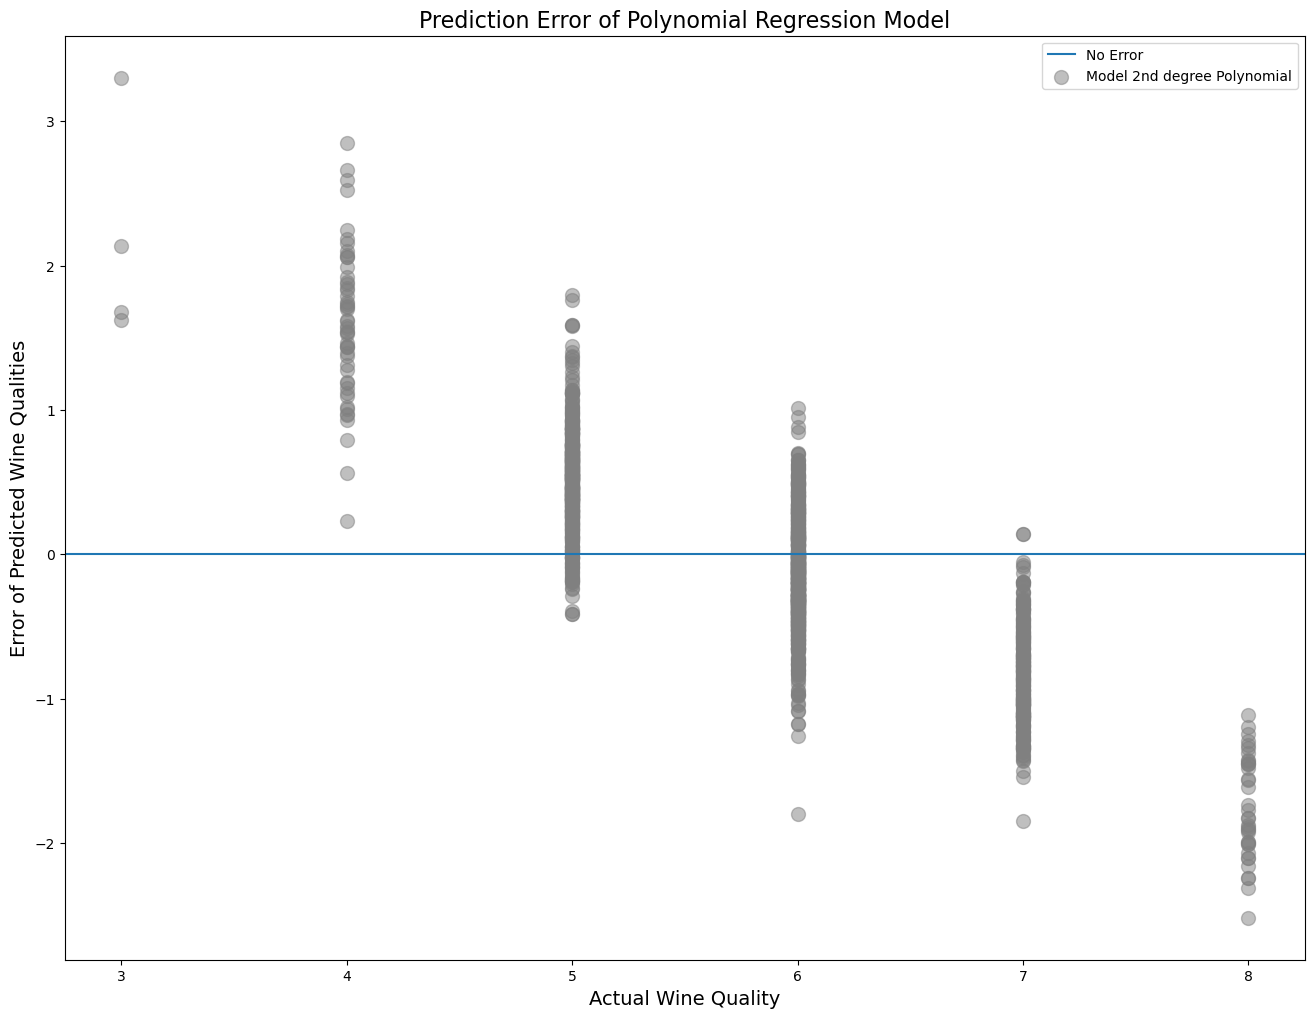

In [55]:
get_pred_error_plot(y_test)